## Introduction

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()


In [2]:
from IPython.display import display

In [41]:
from torchvision import transforms as tfms

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [4]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [5]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [24]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def mk_samples(prompts, g=7.5, seed=100, steps=70, neg_prompt=None):
    bs = len(prompts)
    text = text_enc(prompts)
    if not neg_prompt: 
        uncond = text_enc([""] * bs, text.shape[1])
    else:
        assert len(prompts) == len(neg_prompt)
        uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [25]:
prompts = ["A smiling dinasol"]

height = 512
width = 512

In [26]:
images = mk_samples(prompts)

  0%|          | 0/70 [00:00<?, ?it/s]

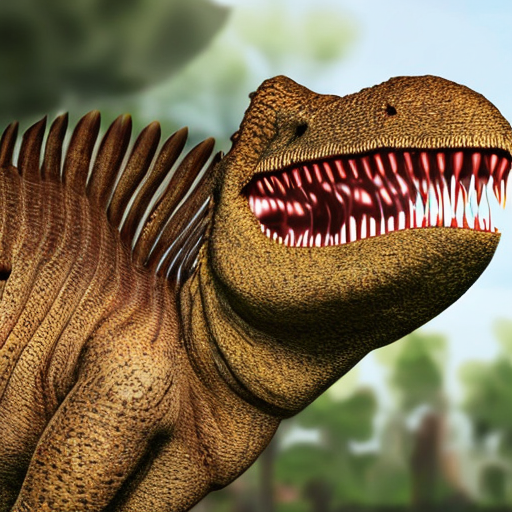

In [28]:
for img in images: display(mk_img(img))
mk_img(img).save(f'img/{0:04}.jpeg')

In [48]:
def load_image(p):
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to("cuda", dtype=torch.float16)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def mk_samples_in(prompt_emb,init_image, g=8, seed=100, steps=70, neg_prompt=None):
    #bs = len(prompts)
    text = prompt_emb
    if not neg_prompt: 
        uncond = text_enc([""], text.shape[1])
    else:
        assert len(prompts) == len(neg_prompt)
        uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)
    
    scheduler.set_timesteps(steps)
    
    encoded = pil_to_latent(init_image)
    start_step = 5
    start_sigma = scheduler.sigmas[start_step]
    noise = torch.randn_like(encoded)

    latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    latents = latents.to("cuda").half()

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step:
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            pred = u + g*(t-u)
            latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return mk_img(vae.decode(1 / 0.18215 * latents).sample[0])

In [95]:
prompts = [
    "A smiling black dinasol", 
    "A smiling gray dinasol",
    "A smiling green dinasol", 
    "A smiling blue dinasol",
    "A smiling white dinasol", 
    "A smiling red dinasol", 
    "A smiling yellow dinasol" 
]

encoded_prompts = text_enc(prompts)
new_interpolated_prompts = []                                  
for idx in range(len(prompts)):
    print(idx)
    new_interpolated_prompts.append(encoded_prompts[idx])
    if idx+1 < len(prompts):
        new_interpolated_prompts.append(0.5*encoded_prompts[idx] + 0.5*encoded_prompts[idx+1])
new_interpolated_prompts = torch.stack(new_interpolated_prompts)

0
1
2
3
4
5
6


In [96]:
for idx in tqdm(range(new_interpolated_prompts.shape[0])):
    print(idx)
    image = mk_samples_in(
        prompt_emb=new_interpolated_prompts[idx,:,:].unsqueeze(0), 
        init_image=load_image(f"./img/{idx:04}.jpeg"),
        g=7.5,
        steps=70,
        seed=1000
    )
    image.save(f"img/{idx+1:04}.jpeg")

  0%|          | 0/13 [00:00<?, ?it/s]

0


  0%|          | 0/70 [00:00<?, ?it/s]

1


  0%|          | 0/70 [00:00<?, ?it/s]

2


  0%|          | 0/70 [00:00<?, ?it/s]

3


  0%|          | 0/70 [00:00<?, ?it/s]

4


  0%|          | 0/70 [00:00<?, ?it/s]

5


  0%|          | 0/70 [00:00<?, ?it/s]

6


  0%|          | 0/70 [00:00<?, ?it/s]

7


  0%|          | 0/70 [00:00<?, ?it/s]

8


  0%|          | 0/70 [00:00<?, ?it/s]

9


  0%|          | 0/70 [00:00<?, ?it/s]

10


  0%|          | 0/70 [00:00<?, ?it/s]

11


  0%|          | 0/70 [00:00<?, ?it/s]

12


  0%|          | 0/70 [00:00<?, ?it/s]

In [97]:
!ffmpeg -v 1 -y -f image2 -framerate 8 -i img/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out3.mp4

In [100]:
!ffmpeg -i out3.mp4 -r 8 -s 512x512 img/output/output3.gif -y

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [82]:
from base64 import b64encode
from IPython.display import HTML

In [98]:
mp4 = open('out3.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)